In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math

In [2]:
total_encoded_values = 0

In [3]:
# Quantization matrices
quantization_matrix = [[16, 11, 10, 16, 24, 40, 51, 61],
                       [12, 12, 14, 19, 26, 58, 60, 55],
                       [14, 13, 16, 24, 40, 57, 69, 56],
                       [14, 17, 22, 29, 51, 87, 80, 62],
                       [18, 22, 37, 56, 68, 109, 103, 77],
                       [24, 35, 55, 64, 81, 104, 113, 92],
                       [49, 64, 78, 87, 103, 121, 120, 101],
                       [72, 92, 95, 98, 112, 100, 103, 99]]

quantization_matrix_cbcr = [[17, 18, 24, 47, 99, 99, 99, 99],
                            [18, 21, 26, 66, 99, 99, 99, 99],
                            [24, 26, 56, 99, 99, 99, 99, 99],
                            [47, 66, 99, 99, 99, 99, 99, 99],
                            [99, 99, 99, 99, 99, 99, 99, 99],
                            [99, 99, 99, 99, 99, 99, 99, 99],
                            [99, 99, 99, 99, 99, 99, 99, 99],
                            [99, 99, 99, 99, 99, 99, 99, 99]]

In [4]:
''' Function for Encoder '''
def zigzag(input):
    #initializing the variables
    #----------------------------------
    h = 0
    v = 0

    vmin = 0
    hmin = 0

    vmax = input.shape[0]
    hmax = input.shape[1]
    
    #print(vmax ,hmax )

    i = 0

    output = np.zeros(( vmax * hmax))
    #----------------------------------

    while ((v < vmax) and (h < hmax)):
    	
        if ((h + v) % 2) == 0:                 # going up
            
            if (v == vmin):
            	#print(1)
                output[i] = input[v, h]        # if we got to the first line

                if (h == hmax):
                    v = v + 1
                else:
                    h = h + 1                        

                i = i + 1

            elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
            	#print(2)
            	output[i] = input[v, h] 
            	v = v + 1
            	i = i + 1

            elif ((v > vmin) and (h < hmax -1 )):    # all other cases
            	#print(3)
            	output[i] = input[v, h] 
            	v = v - 1
            	h = h + 1
            	i = i + 1

        
        else:                                    # going down

        	if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
        		#print(4)
        		output[i] = input[v, h] 
        		h = h + 1
        		i = i + 1
        
        	elif (h == hmin):                  # if we got to the first column
        		#print(5)
        		output[i] = input[v, h] 

        		if (v == vmax -1):
        			h = h + 1
        		else:
        			v = v + 1

        		i = i + 1

        	elif ((v < vmax -1) and (h > hmin)):     # all other cases
        		#print(6)
        		output[i] = input[v, h] 
        		v = v + 1
        		h = h - 1
        		i = i + 1




        if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
        	#print(7)        	
        	output[i] = input[v, h] 
        	break

    #print ('v:',v,', h:',h,', i:',i)
    return output

def JPEG_compress(matrix,n1,n2):
    
    ''' Step-1'''
    matrix = matrix - 128
    matrix = matrix.astype(np.float32)
    
    '''Step-2'''
    dct_matrix = cv2.dct(matrix)
    dct_matrix = dct_matrix.astype(np.float32)
    
    #CHECKING DCT MATRIX
    #print(dct_matrix)
    # print(type(dct_matrix[0][0]))
    
    '''Step-3'''
    q_matrix = np.array(quantization_matrix,dtype='uint8')
    quantization_matrix_resized = cv2.resize(q_matrix, (n2, n1), interpolation=cv2.INTER_LINEAR)
    quantization_matrix_resized = np.array(quantization_matrix_resized,dtype=np.float32)
    quantized_matrix = dct_matrix / quantization_matrix_resized
    rounded_quantization_matrix = np.round(quantized_matrix,2).astype(int)
    
    output = zigzag(rounded_quantization_matrix)
    output = np.array(output,dtype='int')
    return output
    #To print output
    # print(output)
    

def JPEG_compress_color(matrix,n1,n2,type):
    
    ''' Step-1'''
    matrix = matrix - 128
    matrix = matrix.astype(np.float32)
    
    '''Step-2'''
    dct_matrix = cv2.dct(matrix)
    dct_matrix = dct_matrix.astype(np.float32)
    
    #CHECKING DCT MATRIX
    #print(dct_matrix)
    # print(type(dct_matrix[0][0]))
    # print(n1)
    # print(n2)
    '''Step-3'''
    q_matrix = 0
    quantization_matrix_resized = 0
    if(type == 1):
        q_matrix = np.array(quantization_matrix,dtype='uint8')
        quantization_matrix_resized = cv2.resize(q_matrix, (n2, n1), interpolation=cv2.INTER_LINEAR)
    else:
        q_matrix = np.array(quantization_matrix_cbcr,dtype='uint8')
        quantization_matrix_resized = cv2.resize(q_matrix, (n2, n1), interpolation=cv2.INTER_LINEAR)
    
    # print(quantization_matrix_resized.shape)
    quantization_matrix_resized = np.array(quantization_matrix_resized,dtype=np.float32)
    quantized_matrix = dct_matrix / quantization_matrix_resized
    rounded_quantization_matrix = np.round(quantized_matrix,2).astype(int)
    
    output = zigzag(rounded_quantization_matrix)
    output = np.array(output,dtype='int')
    
    return output
    #To print output
    # print(output)


def JPEG_gray(filename,blockSize,num_coeff):
    #Read the file
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    #CHECK FOR IMAGE PRINTING
    # cv2.imshow('img',img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    #BlockSize
    n1=0
    n2=0
    if(blockSize == -1):
        n1 = img.shape[0]
        n2 = img.shape[1]
    else:
        n1 = blockSize
        n2 = blockSize
    
    #CHECK FOR n1,n2
    # print(f"n1: {n1} n2:{n2}")
    # print(img.shape)
    
    #padding
    pad_h = img.shape[0]%n1
    pad_w = img.shape[1]%n2
    
    if(pad_h!=0):
        pad_h = n1-pad_h
        lst = []
        for i in range(pad_h):
            lst2 = []
            for j in range(img.shape[1]):
                lst2.append(0)
            lst.append(lst2)
        img = np.append(img,lst,axis=0)
        
    if(pad_w!=0):
        pad_w = n2-pad_w
        newHeight = img.shape[0]
        zeros = np.zeros((newHeight,pad_w),dtype=int)
        img = np.hstack((img,zeros))
    
    
    # print(img.shape)
    global total_encoded_values
    
    file = open('jpeg_encoded.txt','w')
    file.write(str(img.shape[0])+" ")
    file.write(str(img.shape[1])+"\n")
    i = 0
    while i<img.shape[0]:
        j = 0
        while j<img.shape[1]:
            #Formation of matrix with all zeros
            matrix = np.zeros((n1,n2))
            for k in range(n1):
                for l in range(n2):
                    matrix[k][l] = img[i+k][j+l]
            
            output = JPEG_compress(matrix,n1,n2)
            
            total_encoded_values += num_coeff 
            
            for value in output:
                file.write(str(value)+" ")
            file.write("\n")
            j = j + n2
        i = i + n1
    

def JPEG_color(filename,blockSize,num_coeff):
    #Read the file
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    
    # CHECK FOR IMAGE PRINTING
    # cv2.imshow('img',img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
    #Extracting y,cb,cr channels
    y,cr,cb = cv2.split(img)
    
    #CHECK FOR Y,CB,CR
    # cv2.imshow('img',y)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # print(y)
    # print(cb)
    # print(cr)
    
    #BlockSize
    n1=0
    n2=0
    if(blockSize == -1):
        n1 = img.shape[0]
        n2 = img.shape[1]
    else:
        n1 = blockSize
        n2 = blockSize
    
    #CHECK FOR n1,n2
    # print(f"n1: {n1} n2:{n2}")
    
    print(img.shape)
    #padding
    pad_h = img.shape[0]%n1
    pad_w = img.shape[1]%n2
    
    if(pad_h!=0):
        pad_h = n1-pad_h
        lst = []
        for i in range(pad_h):
            lst2 = []
            for j in range(img.shape[1]):
                lst2.append(0)
            lst.append(lst2)
        y = np.append(y,lst,axis=0)
        cr = np.append(cr,lst,axis=0)
        cb = np.append(cb,lst,axis=0)
        
    if(pad_w!=0):
        pad_w = n2-pad_w
        newHeight = y.shape[0]
        zeros = np.zeros((newHeight,pad_w),dtype=int)
        y = np.hstack((y,zeros))
        cr = np.hstack((cr,zeros))
        cb = np.hstack((cb,zeros))
    
    print(img.shape)
    
    global total_encoded_values
    
    file = open('jpeg_encoded.txt','w')
    file.write(str(y.shape[0])+" ")
    file.write(str(y.shape[1])+"\n")
    i = 0
    while i < y.shape[0]:
        j = 0
        while j < y.shape[1]:
            matrix1 = np.zeros((n1,n2))
            matrix2 = np.zeros((n1,n2))
            matrix3 = np.zeros((n1,n2))
            for k in range(n1):
                for l in range(n2):
                    matrix1[k][l] = y[i+k][j+l]
                    matrix2[k][l] = cr[i+k][j+l]
                    matrix3[k][l] = cb[i+k][j+l]
            output1 = JPEG_compress_color(matrix1,n1,n2,1)
            output2 = JPEG_compress_color(matrix2,n1,n2,2)
            output3 = JPEG_compress_color(matrix3,n1,n2,3)
            
            total_encoded_values += num_coeff
            count = 0
            file.write("Y: ")
            for value in output1:
                file.write(str(value)+" ")
                count = count + 1
                # if(count == num_coeff):
                    # break
            file.write("\n")
            
            count = 0
            file.write("CR: ")
            for value in output2:
                file.write(str(value)+" ")
                count = count + 1
                # if(count == num_coeff):
                    # break
            file.write("\n")
            
            count = 0
            file.write("CB: ")
            for value in output3:
                file.write(str(value)+" ")
                count = count + 1
                # if(count == num_coeff):
                    # break
            file.write("\n")
            
            j = j + n2
        i = i + n1
 
 
def JPEG_encoder(filename,blockSize,num_coeff,isColoured):
    if(isColoured):
        JPEG_color(filename,blockSize,num_coeff)
    else:
        JPEG_gray(filename,blockSize,num_coeff)           
        

In [5]:
''' Function for decoder '''

def inverse_zigzag(input, vmax, hmax):
	
	#print input.shape

	# initializing the variables
	#----------------------------------
	h = 0
	v = 0

	vmin = 0
	hmin = 0

	output = np.zeros((vmax, hmax))

	i = 0
    #----------------------------------

	while ((v < vmax) and (h < hmax)): 
		#print ('v:',v,', h:',h,', i:',i)   	
		if ((h + v) % 2) == 0:                 # going up
            
			if (v == vmin):
				#print(1)
				
				output[v, h] = input[i]        # if we got to the first line

				if (h == hmax):
					v = v + 1
				else:
					h = h + 1                        

				i = i + 1

			elif ((h == hmax -1 ) and (v < vmax)):   # if we got to the last column
				#print(2)
				output[v, h] = input[i] 
				v = v + 1
				i = i + 1

			elif ((v > vmin) and (h < hmax -1 )):    # all other cases
				#print(3)
				output[v, h] = input[i] 
				v = v - 1
				h = h + 1
				i = i + 1

        
		else:                                    # going down

			if ((v == vmax -1) and (h <= hmax -1)):       # if we got to the last line
				#print(4)
				output[v, h] = input[i] 
				h = h + 1
				i = i + 1
        
			elif (h == hmin):                  # if we got to the first column
				#print(5)
				output[v, h] = input[i] 
				if (v == vmax -1):
					h = h + 1
				else:
					v = v + 1
				i = i + 1
        		        		
			elif((v < vmax -1) and (h > hmin)):     # all other cases
				output[v, h] = input[i] 
				v = v + 1
				h = h - 1
				i = i + 1




		if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
			#print(7)        	
			output[v, h] = input[i] 
			break


	return output


def JPEG_decompress(lst,n1,n2):
    
    '''Step-1'''
    inv_zigzag = inverse_zigzag(lst,n1,n2)
    #CHECKING FOR INVERSE ZIGZAG ARRAY
    # file = open('inverseZigZag.txt','a')
    # for lst in inv_zigzag:
    #     for value in lst:
    #         file.write(str(value)+" ")
    #     file.write("\n")
    
    '''Step-2'''
    q_matrix = np.array(quantization_matrix,dtype='uint8')
    quantization_matrix_resized = cv2.resize(q_matrix, (n2, n1), interpolation=cv2.INTER_LINEAR)
    quantization_matrix_resized = np.array(quantization_matrix_resized,dtype=np.float32)
    inv_quantized_matrix = inv_zigzag * quantization_matrix_resized
    # print(type(inv_quantized_matrix[0][0]))
    
    '''Step-3'''
    inv_dct = cv2.idct(inv_quantized_matrix)
    inv_dct_round = np.round(inv_dct,2).astype(int)
    
    '''Step-4'''
    matrix = inv_dct_round + 128
    return matrix
    
    
    
def JPEG_decompress_color(lst,n1,n2,type):
    
    '''Step-1'''
    inv_zigzag = inverse_zigzag(lst,n1,n2)
    #CHECKING FOR INVERSE ZIGZAG ARRAY
    # file = open('inverseZigZag.txt','a')
    # for lst in inv_zigzag:
    #     for value in lst:
    #         file.write(str(value)+" ")
    #     file.write("\n")
    
    '''Step-2'''
    q_matrix = 0
    if(type==1):
        q_matrix = np.array(quantization_matrix,dtype='uint8')
    else:
        q_matrix = np.array(quantization_matrix_cbcr,dtype='uint8')
    # q_matrix = np.array(quantization_matrix,dtype='uint8')
    quantization_matrix_resized = cv2.resize(q_matrix, (n2, n1), interpolation=cv2.INTER_LINEAR)
    quantization_matrix_resized = np.array(quantization_matrix_resized,dtype=np.float32)
    inv_quantized_matrix = inv_zigzag * quantization_matrix_resized
    # print(type(inv_quantized_matrix[0][0]))
    
    '''Step-3'''
    inv_dct = cv2.idct(inv_quantized_matrix)
    inv_dct_round = np.round(inv_dct,2).astype(int)
    
    '''Step-4'''
    matrix = inv_dct_round + 128
    return matrix   


def JPEG_decode_gray(filename,blockSize,num_coeff):
    
    file = open(filename,'r')
    first_line = file.readline().strip('\n').strip(' ').split(' ')
    height = int(first_line[0])
    width = int(first_line[1])
    
    #BlockSize
    n1=0
    n2=0
    if(blockSize == -1):
        n1 = height
        n2 = width
    else:
        n1 = blockSize
        n2 = blockSize
    
    #CHECK FOR n1,n2
    # print(f"n1: {n1} n2:{n2}")
    
    # Reading the file
    data = []
    for line in file:
        arr = line.strip('\n').strip(' ').split(' ')
        lst = []
        for value in arr:
            lst.append(int(value))
            if(len(lst) == num_coeff):
                break
        while(len(lst)!=n1*n2):
            lst.append(0)
        data.append(lst)
    
    #CHECKING DATA ARRAY
    # file = open('c.txt','w')
    # for lst in data:
    #     for value in lst:
    #         file.write(str(value)+" ")
    #     file.write("\n")
    
    reconstructed_img = np.zeros((height,width),dtype=int)
    pad_h = height%n1
    pad_w = width%n2
    
    if(pad_h!=0):
        pad_h = n1-pad_h
        lst = []
        for i in range(pad_h):
            lst2 = []
            for j in range(width):
                lst2.append(0)
            lst.append(lst2)
        reconstructed_img = np.append(reconstructed_img,lst,axis=0)
        
    if(pad_w!=0):
        pad_w = n2-pad_w
        newHeight = reconstructed_img.shape[0]
        zeros = np.zeros((newHeight,pad_w))
        reconstructed_img = np.hstack((reconstructed_img,zeros))
    
    
    s1 = 0
    s2 = 0
    # x = height//n1
    # y = width//n2
    # col = 0
    for lst in data:
        matrix = JPEG_decompress(lst,n1,n2)
        matrix = np.array(matrix)
        for i in range(matrix.shape[0]):
            for j in  range(matrix.shape[1]):
                reconstructed_img[s1+i][s2+j] = matrix[i][j]
                # col = col + 1
        s2 = s2 + n2
        if(s2>=width):
            s1 = s1 + n1
            s2 = 0
    
    # plt.imshow(reconstructed_img,cmap='gray')
    return reconstructed_img


def JPEG_decode_color(filename,blockSize,num_coeff):
    # print("HELLO")
    file = open(filename,'r')
    first_line = file.readline().strip('\n').strip(' ').split(' ')
    height = int(first_line[0])
    width = int(first_line[1])
    
    #BlockSize
    n1=0
    n2=0
    if(blockSize == -1):
        n1 = height
        n2 = width
    else:
        n1 = blockSize
        n2 = blockSize
    
    #CHECK FOR n1,n2
    # print(f"n1: {n1} n2:{n2}")
    
    # Reading the file
    data = []
    for line in file:
        line1 = line.strip('\n').strip(' ').split(' ')
        line2 = file.readline().strip('\n').strip(' ').split(' ')
        line3 = file.readline().strip('\n').strip(' ').split(' ')
        # print(line1)
        # print(line2)
        # print(line3)
        
        lst1 = []
        for value in line1[1:]:
            lst1.append(value)
            if(len(lst1) == num_coeff):
                break
            
        lst2 = []
        for value in line2[1:]:
            lst2.append(value)
            if(len(lst2) == num_coeff):
                break
            
        lst3 = []
        for value in line3[1:]:
            lst3.append(value)
            if(len(lst3) == num_coeff):
                break
        
        while(len(lst1)!=n1*n2):
            lst1.append(0)
            lst2.append(0)
            lst3.append(0)
            
        data.append([lst1,lst2,lst3])
        
    
    #CHECKING DATA ARRAY
    # file = open('data.txt','w')
    # for lst in data:
    #     lst1,lst2,lst3 = lst
    #     for value in lst1:
    #         file.write(str(value)+" ")
    #     file.write("\n")
    #     for value in lst2:
    #         file.write(str(value)+" ")
    #     file.write("\n")
    #     for value in lst3:
    #         file.write(str(value)+" ")
    #     file.write("\n")
    
    reconstructed_img = np.zeros((height,width,3),dtype=int)
    pad_h = height%n1
    pad_w = width%n2
    if(pad_h!=0):
        pad_h = n1-pad_h
        lst = []
        for i in range(pad_h):
            lst2 = []
            for j in range(width):
                lst2.append([0,0,0])
            lst.append(lst2)
        reconstructed_img = np.append(reconstructed_img,lst,axis=0)
        
    if(pad_w!=0):
        pad_w = n2-pad_w
        newHeight = reconstructed_img.shape[0]
        zeros = np.zeros((newHeight,pad_w,3))
        # print(zeros)
        reconstructed_img = np.hstack((reconstructed_img,zeros))
        
    # print(reconstructed_img)
    s1 = 0
    s2 = 0
    # x = height//n1
    # y = width//n2
    # col = 0
    for lst in data:
        lst1,lst2,lst3 = lst
        matrix1 = JPEG_decompress_color(lst1,n1,n2,1)
        matrix2 = JPEG_decompress_color(lst2,n1,n2,2)
        matrix3 = JPEG_decompress_color(lst3,n1,n2,3)
        
        matrix1 = np.array(matrix1)
        matrix2 = np.array(matrix2)
        matrix3 = np.array(matrix3)
        
        matrix = cv2.merge([matrix1,matrix2,matrix3])
        # print(matrix)
        for i in range(matrix.shape[0]):
            for j in  range(matrix.shape[1]):
                reconstructed_img[s1+i][s2+j] = matrix[i][j]
                # col = col + 1
        s2 = s2 + n2
        if(s2>=width):
            s1 = s1 + n1
            s2 = 0
    

    # plt.imshow(reconstructed_img)
    return reconstructed_img


def JPEG_decoder(filename,blockSize,num_coeff,isColoured):
    if(isColoured):
        return JPEG_decode_color(filename,blockSize,num_coeff)
    else:
        return JPEG_decode_gray(filename,blockSize,num_coeff)     

In [6]:
'''
                    CHANGE THE FILENAME, BLOCKSIZE, NO. OF COEFFICIENT, ISCOLOURED HERE
'''

filename = 'kodim03.png'
blockSize = 8
num_coeff = -1
isColoured = True

JPEG_encoder(filename,blockSize,num_coeff,isColoured)

(512, 768, 3)
(512, 768, 3)


In [7]:
filename1 = 'jpeg_encoded.txt'

decoded_Img = JPEG_decoder(filename1,blockSize,num_coeff,isColoured)
size_with_padding = decoded_Img.shape
img = cv2.imread(filename)

if(isColoured):
    decoded_Img = decoded_Img[0:img.shape[0],0:img.shape[1]]
    decoded_Img = decoded_Img.astype(np.uint8)
    decoded_Img = cv2.cvtColor(decoded_Img,cv2.COLOR_YCR_CB2RGB)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
else:
    decoded_Img = decoded_Img[0:img.shape[0],0:img.shape[1]]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # plt.imshow(decoded_Img)


# STATS:

1. IMAGES PLOT

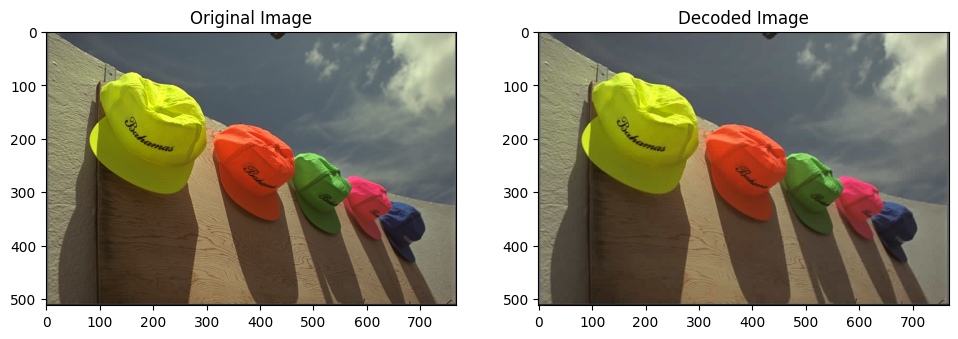

In [8]:
if(isColoured):
    plt.figure(figsize=[18,5])
    plt.subplot(131); plt.imshow(img); plt.title('Original Image')
    plt.subplot(132); plt.imshow(decoded_Img); plt.title('Decoded Image')
else:
    plt.figure(figsize=[18,5])
    plt.subplot(131); plt.imshow(img,cmap='gray'); plt.title('Original Image')
    plt.subplot(132); plt.imshow(decoded_Img,cmap='gray'); plt.title('Decoded Image')

1. RMSE ERROR

In [9]:
difference = img - decoded_Img
sq_diff = difference ** 2
mean_sq_diff = sq_diff.mean()
rmse = np.sqrt(mean_sq_diff)
print(rmse)

4.906260107722471


2. COMPRESSION RATIO


In [10]:

compression_ratio = 0
if(num_coeff == -1):
    compression_ratio = 1
else:
    compression_ratio = (size_with_padding[0]*size_with_padding[1])/total_encoded_values
print(compression_ratio)

1


3. PSNR

In [11]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

value = PSNR(img,decoded_Img)
print(value)

34.31579223247799
